In [1]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


In [2]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('../data_generators/stations_yrd.csv')
micro_name = list(df["station_id"])

In [3]:
import pandas as pd
import plotly.express as px

fig = px.scatter(
    df,
    x="lon",
    y="lat",
    text="station_id",
    hover_data=["station_name", "city"]
)
fig.update_traces(textposition='top center')
fig.show()

# 数据展示

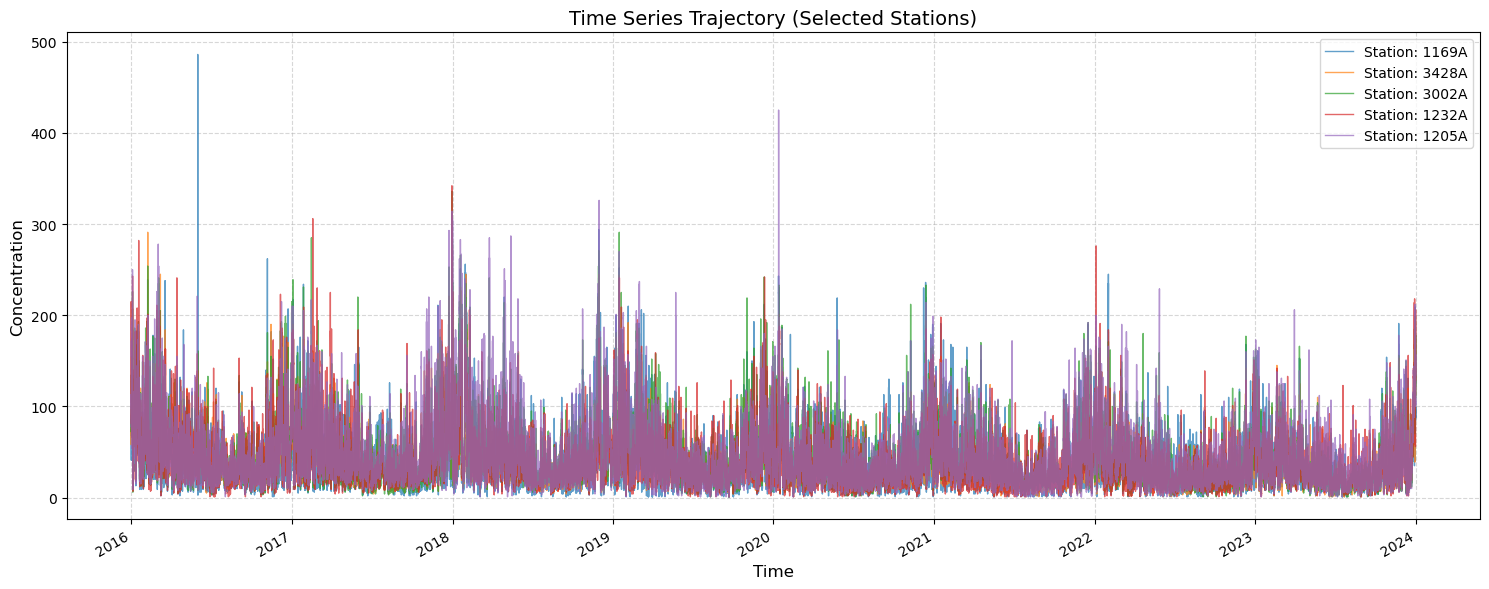

In [4]:
import matplotlib.pyplot as plt

num_stations_to_plot = 5
pm25 = ds['PM2.5']
o3 = ds['O3']
times = ds['time'].values
stations = ds['station'].values

np.random.seed(42)
selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# # 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
# selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data_o3 = o3.isel(station=idx).values
    station_data_pm25 = pm25.isel(station=idx).values
    
    plt.plot(times, station_data_pm25, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
x_data = pm25.values
x_data.shape

(70128, 127)

In [26]:
ide = ps.IdentityLibrary()
n_delays = 2
delay_interval = 5
H, new_names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
H.shape, new_names

((70118, 381),
 ['1141A',
  '1142A',
  '1143A',
  '1144A',
  '1145A',
  '1147A',
  '1148A',
  '1149A',
  '1150A',
  '1151A',
  '1152A',
  '1153A',
  '1154A',
  '1155A',
  '1156A',
  '1157A',
  '1158A',
  '1159A',
  '1160A',
  '1162A',
  '1163A',
  '1164A',
  '1165A',
  '1166A',
  '1167A',
  '1168A',
  '1169A',
  '1170A',
  '1171A',
  '1172A',
  '1186A',
  '1188A',
  '1189A',
  '1190A',
  '1191A',
  '1192A',
  '1193A',
  '1194A',
  '1195A',
  '1196A',
  '1200A',
  '1201A',
  '1203A',
  '1204A',
  '1205A',
  '1206A',
  '1207A',
  '1209A',
  '1223A',
  '1224A',
  '1226A',
  '1227A',
  '1228A',
  '1230A',
  '1231A',
  '1232A',
  '1233A',
  '1234A',
  '1235A',
  '1236A',
  '1239A',
  '1240A',
  '1241A',
  '1247A',
  '1250A',
  '1252A',
  '1253A',
  '1255A',
  '1256A',
  '1257A',
  '1258A',
  '1259A',
  '1260A',
  '2869A',
  '2870A',
  '2871A',
  '2872A',
  '2873A',
  '2907A',
  '2921A',
  '2997A',
  '3002A',
  '3003A',
  '3010A',
  '3164A',
  '3195A',
  '3265A',
  '3266A',
  '3268A',
  '326

In [8]:
discrete_time = True
dt = 1
model, results = fit_sindy_sr3_robust(H, ide, new_names, penalty='l1', discrete_time=discrete_time, max_iter=500)

开始使用 L1 范数扫描 20 个参数...


100%|██████████| 20/20 [59:11<00:00, 177.59s/it]



最佳模型 (aic) | Penalty: l1
Param (Thr/Lam): 1.000e-01
Test MSE: 2.8114e+01
Complexity: 136008
(1141A)[k+1] = 0.536 1141A[k] + -0.026 1142A[k] + 0.072 1143A[k] + -0.017 1144A[k] + 0.075 1145A[k] + 0.072 1147A[k] + 0.039 1148A[k] + -0.010 1149A[k] + -0.005 1151A[k] + -0.001 1152A[k] + 0.012 1153A[k] + -0.006 1154A[k] + 0.011 1155A[k] + 0.002 1156A[k] + -0.005 1157A[k] + -0.004 1158A[k] + 0.012 1159A[k] + -0.019 1160A[k] + -0.010 1162A[k] + -0.029 1163A[k] + 0.007 1164A[k] + 0.008 1165A[k] + 0.017 1166A[k] + 0.014 1167A[k] + -0.014 1168A[k] + 0.032 1169A[k] + 0.004 1170A[k] + 0.042 1171A[k] + -0.012 1172A[k] + 0.007 1186A[k] + -0.011 1188A[k] + -0.010 1189A[k] + 0.016 1190A[k] + -0.017 1191A[k] + -0.013 1192A[k] + -0.009 1193A[k] + 0.005 1194A[k] + 0.009 1195A[k] + -0.002 1196A[k] + 0.019 1200A[k] + 0.012 1201A[k] + 0.012 1203A[k] + 0.006 1205A[k] + 0.001 1206A[k] + -0.008 1207A[k] + 0.007 1209A[k] + 0.003 1223A[k] + -0.004 1224A[k] + -0.002 1226A[k] + -0.005 1227A[k] + -0.008 1228A[k] + -

In [27]:
for r in results:
    print('thr', r['thr'])
    print('mse', r['mse'])
    print('score', r['score'])
    
model.score(H, t=dt)

thr 0.1
mse 28.11433672001537
score 318803.9858086463
thr 0.06158482110660261
mse 28.119900318077175
score 326358.76076936716
thr 0.03792690190732246
mse 28.12220882609541
score 331027.91202478623
thr 0.023357214690901212
mse 28.122702207962995
score 333876.1580625942
thr 0.01438449888287663
mse 28.122654248341142
score 335378.13414646033
thr 0.008858667904100823
mse 28.12259270360044
score 336180.10345574457
thr 0.005455594781168515
mse 28.12265249652685
score 336562.13327287836
thr 0.003359818286283781
mse 28.12254141640055
score 336756.0778801387
thr 0.00206913808111479
mse 28.12256759761342
score 336834.0909360412
thr 0.0012742749857031334
mse 28.12255210452406
score 336860.0832100345
thr 0.0007847599703514606
mse 28.122549576115514
score 336880.08194918156
thr 0.0004832930238571752
mse 28.122564055769875
score 336882.08916981495
thr 0.00029763514416313193
mse 28.12255410754548
score 336886.0842088902
thr 4.281332398719396e-05
mse 28.12255437145317
score 336886.08434049424
thr 1e-0

0.9505563523986584

In [12]:
step_pred = 5
t = range(step_pred)
init_data = H[0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 381)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_41543/2734313379.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



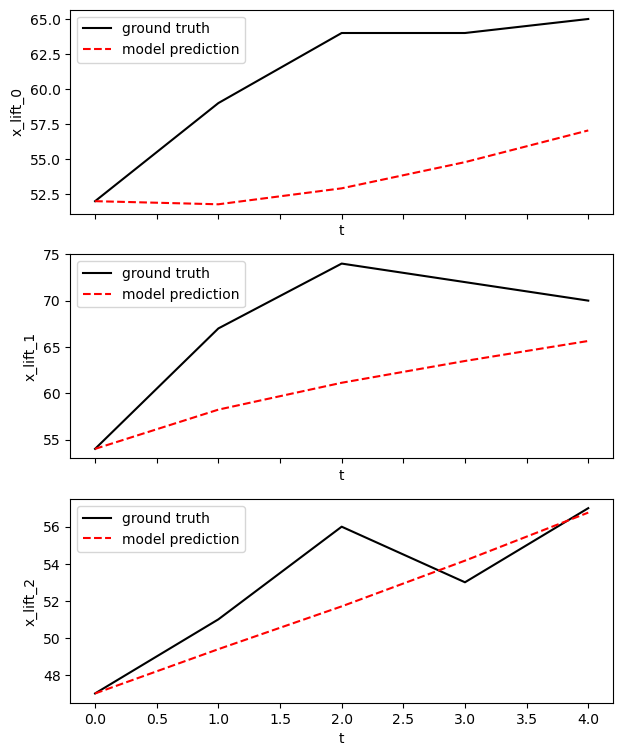

In [13]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(H[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

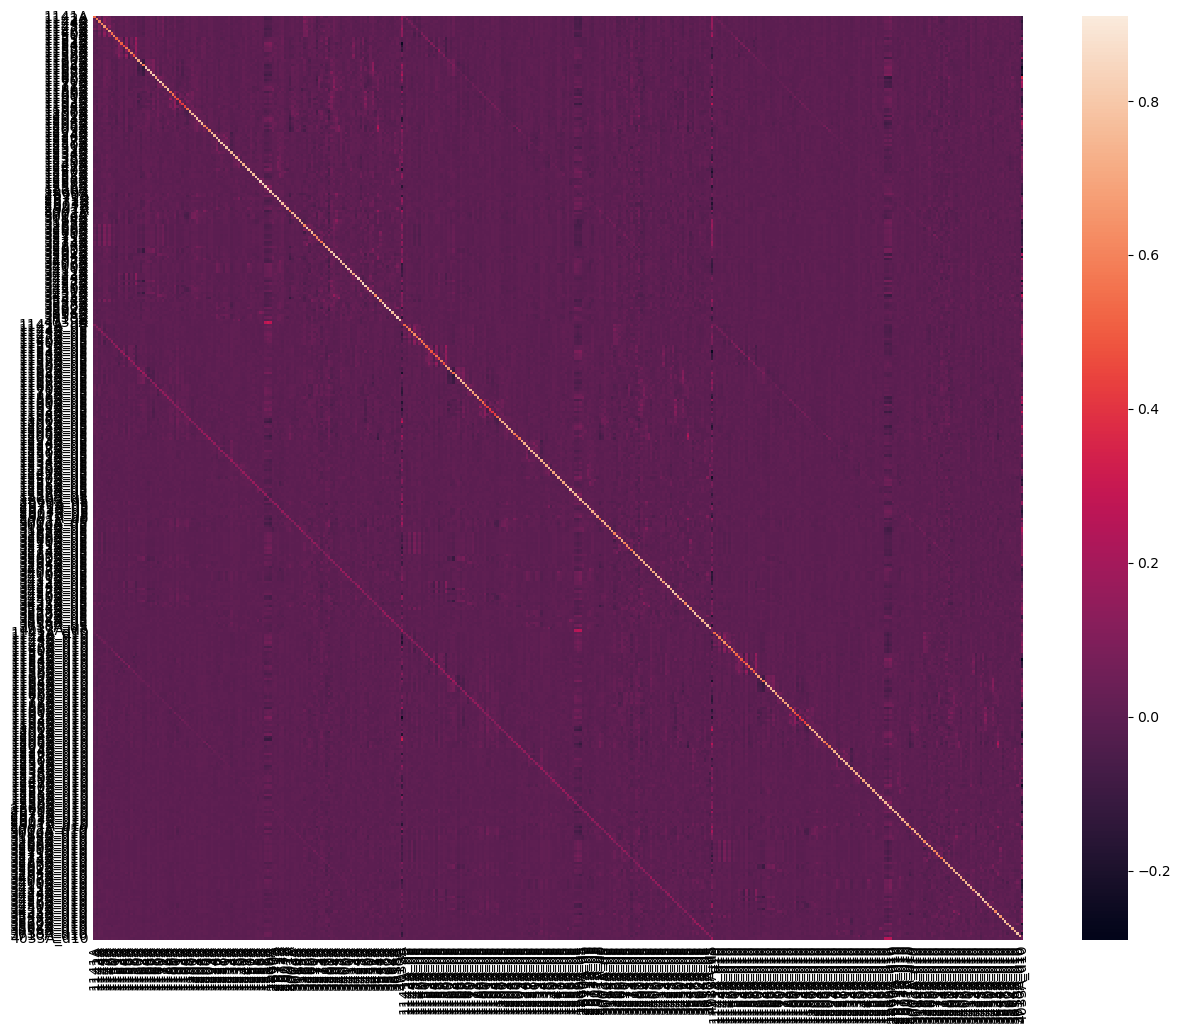

In [14]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=new_names, yticklabels=new_names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

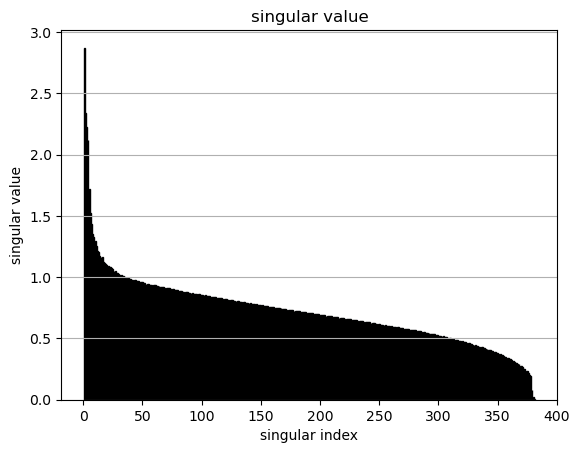

In [15]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

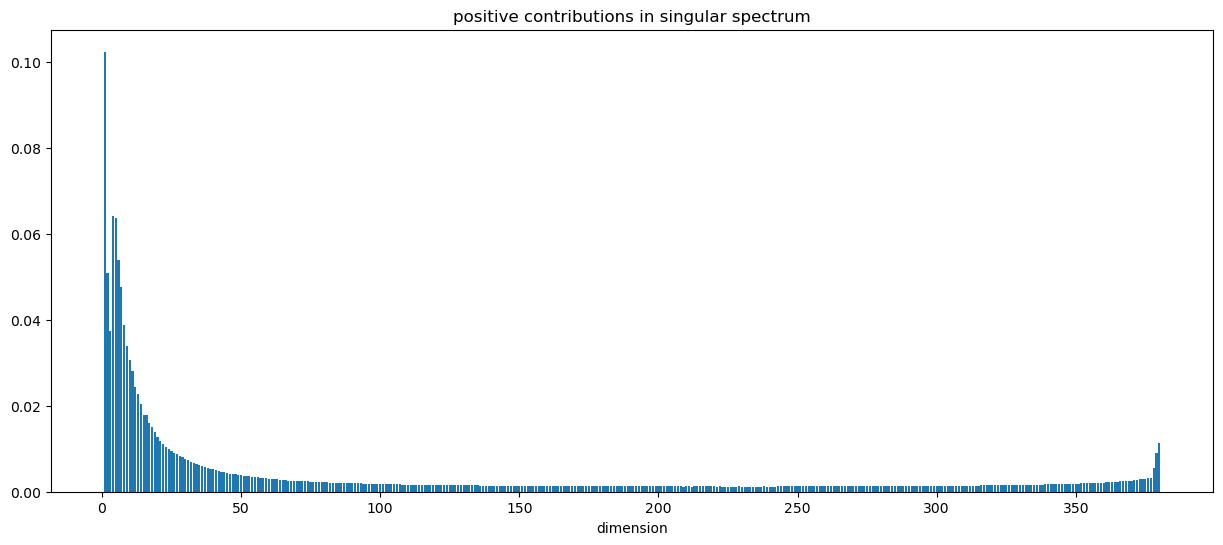

In [16]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [17]:
print(compute_entropy(diff))

7.185788795935141


In [18]:
rank = 3
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

1.7571340374028521


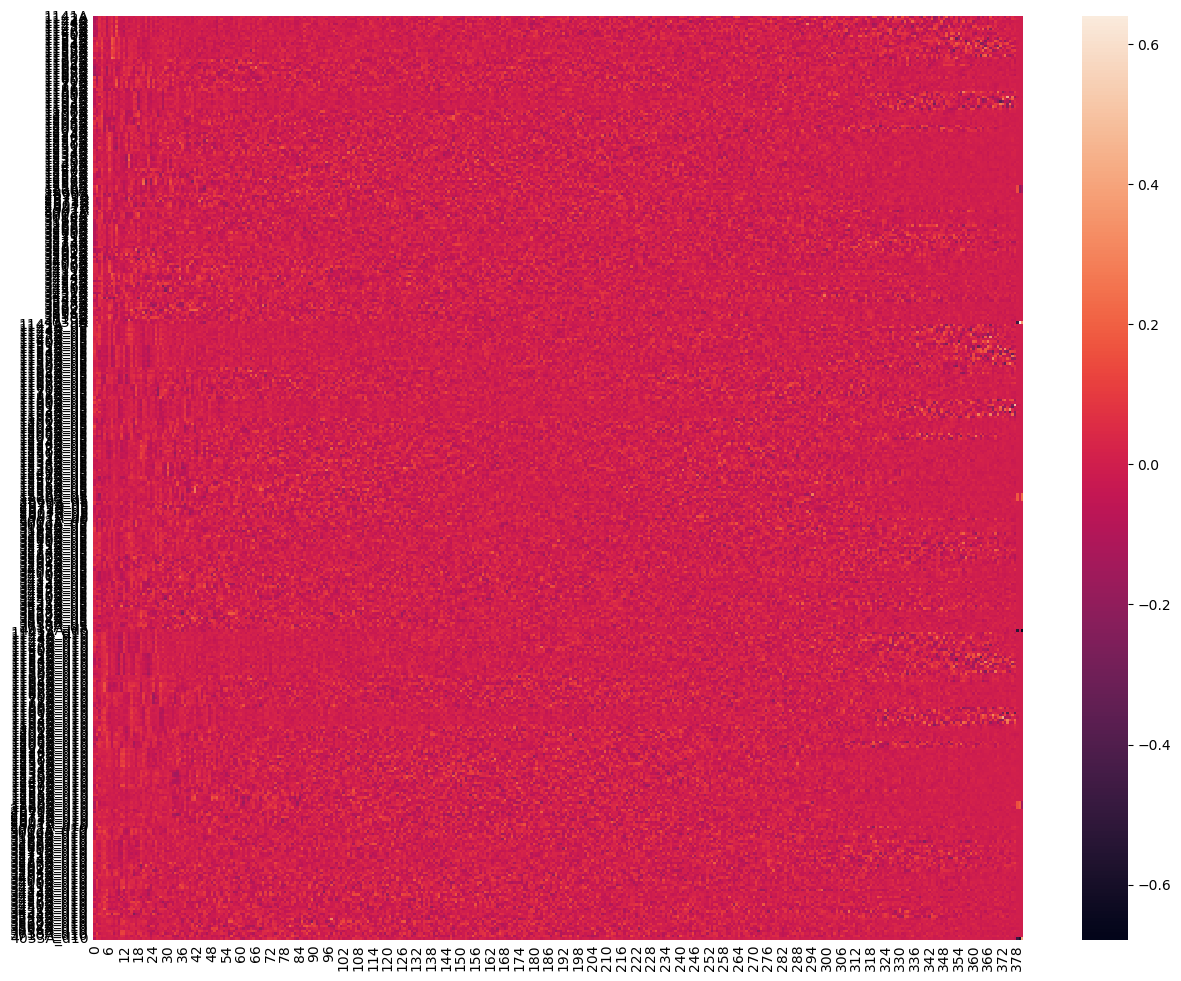

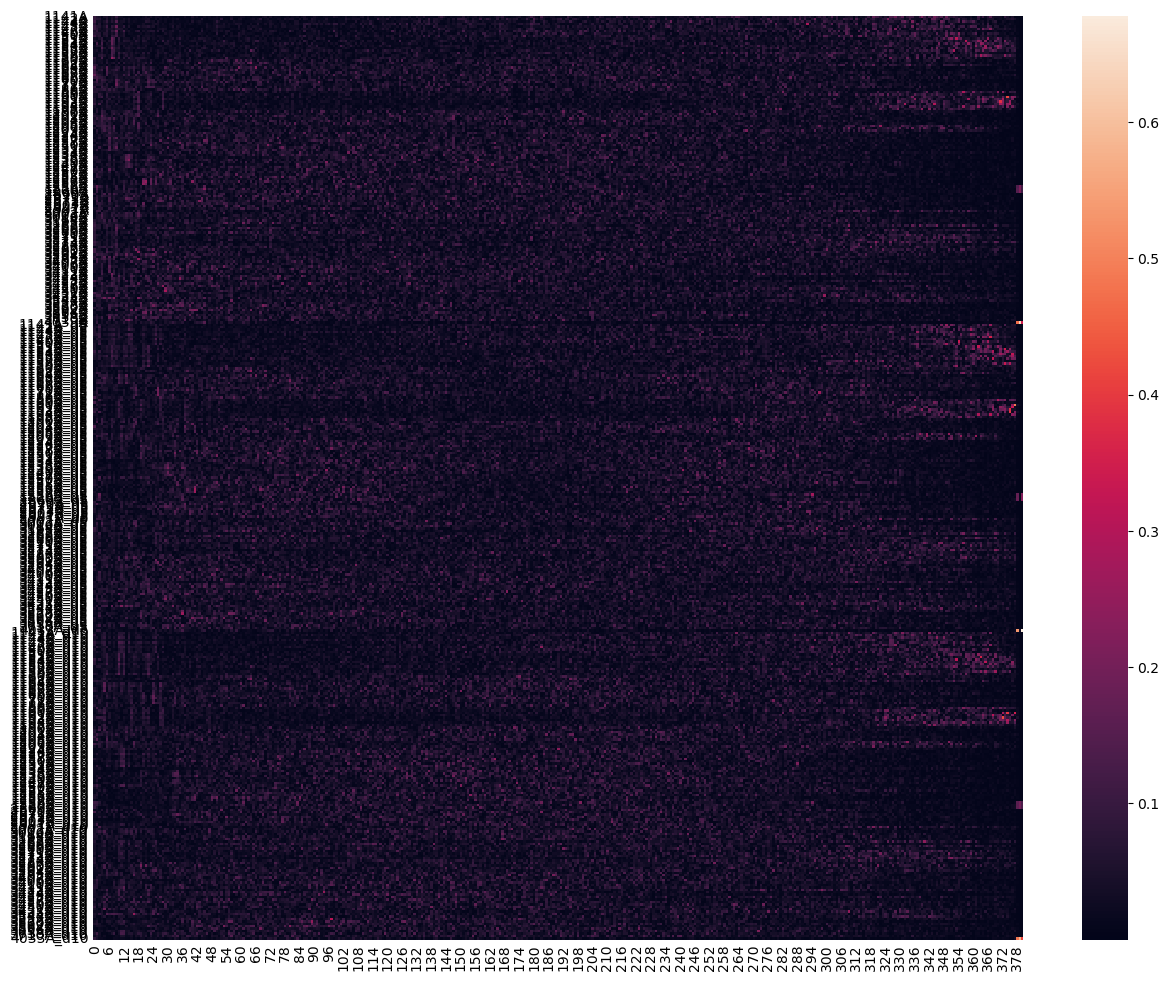

In [19]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

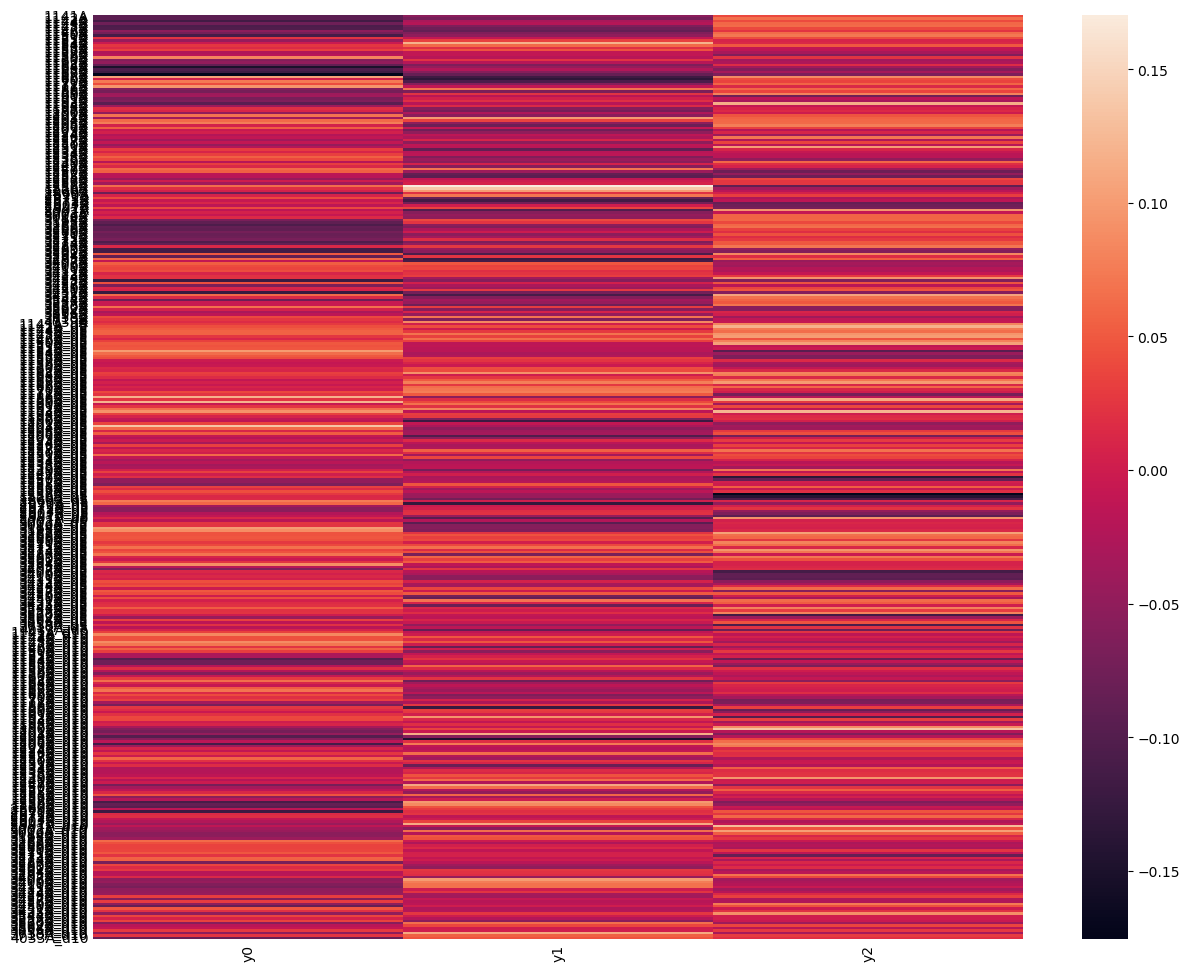

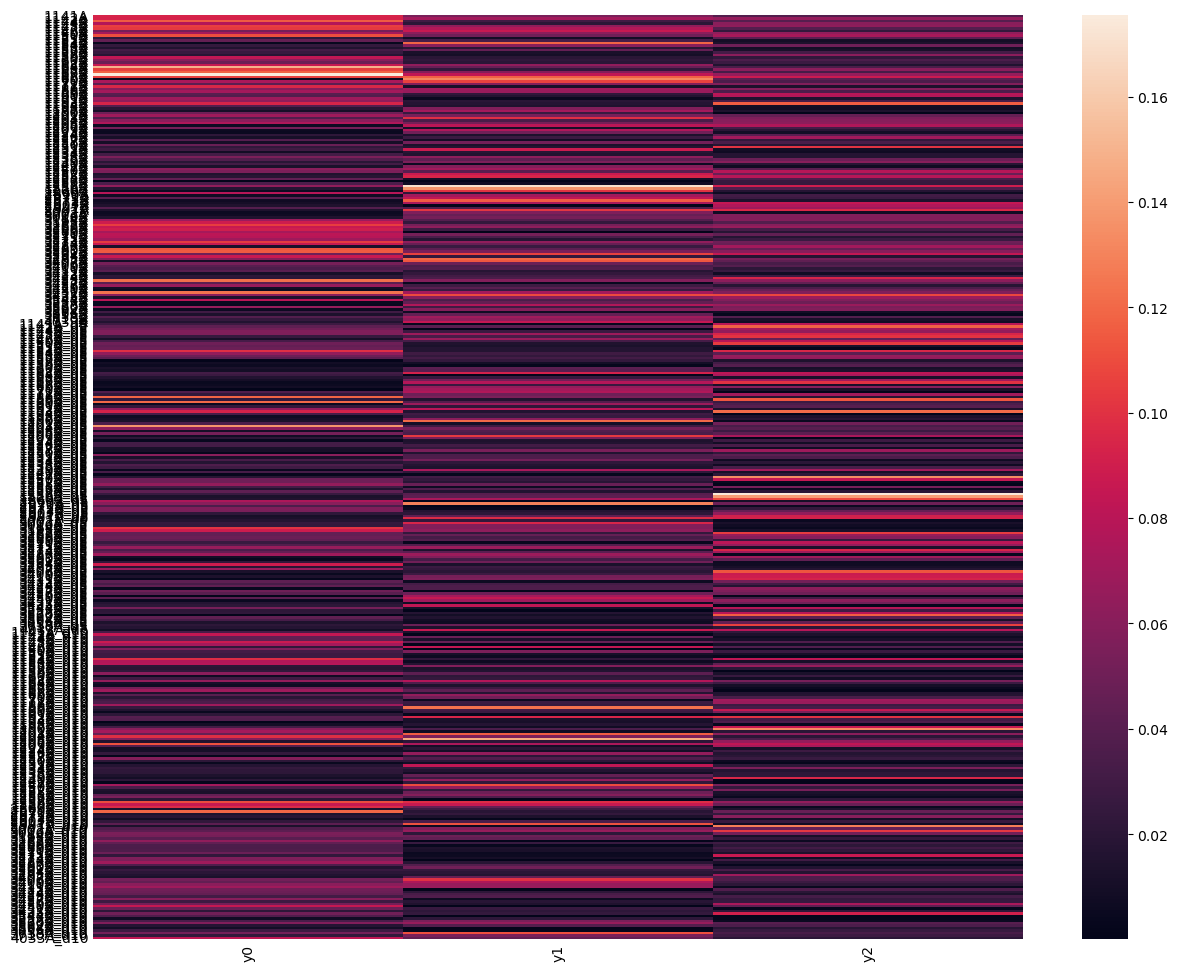

In [20]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [21]:
cg_list = []

n = x_data.shape[1]
for i in range(n_delays+1):
    cg_list.append(U_abs[i*n:(i+1)*n, :rank])
len(cg_list)

3

In [22]:
for i,cg in enumerate(cg_list):
    plot_station(df, cg, delay=i)

In [23]:
coarse_grain_coff = U_abs[:, :rank]
print_equations(coarse_grain_coff, new_names, macro_name)

y0 = 0.0935 * 1141A + 0.0928 * 1142A + 0.1157 * 1143A + 0.0776 * 1144A + 0.1058 * 1145A + 0.1034 * 1147A + 0.0529 * 1148A + 0.0725 * 1149A + 0.1111 * 1150A + 0.0233 * 1151A + 0.0452 * 1152A + 0.0038 * 1153A + 0.0244 * 1154A + 0.0157 * 1155A + 0.0315 * 1156A + 0.0260 * 1157A + 0.0184 * 1158A + 0.0833 * 1159A + 0.0607 * 1160A + 0.0492 * 1162A + 0.0865 * 1163A + 0.1501 * 1164A + 0.1058 * 1165A + 0.1177 * 1166A + 0.1755 * 1167A + 0.1050 * 1168A + 0.0043 * 1169A + 0.0736 * 1170A + 0.0414 * 1171A + 0.0952 * 1172A + 0.0594 * 1186A + 0.0711 * 1188A + 0.0401 * 1189A + 0.0372 * 1190A + 0.0688 * 1191A + 0.0632 * 1192A + 0.0938 * 1193A + 0.0386 * 1194A + 0.0195 * 1195A + 0.0107 * 1196A + 0.0497 * 1200A + 0.0699 * 1201A + 0.0372 * 1203A + 0.0616 * 1204A + 0.0762 * 1205A + 0.0067 * 1206A + 0.0534 * 1207A + 0.0061 * 1209A + 0.0054 * 1223A + 0.0218 * 1224A + 0.0107 * 1226A + 0.0389 * 1227A + 0.0103 * 1228A + 0.0469 * 1230A + 0.0229 * 1231A + 0.0291 * 1232A + 0.0087 * 1233A + 0.0313 * 1234A + 0.0555 * 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_41543/3056197561.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



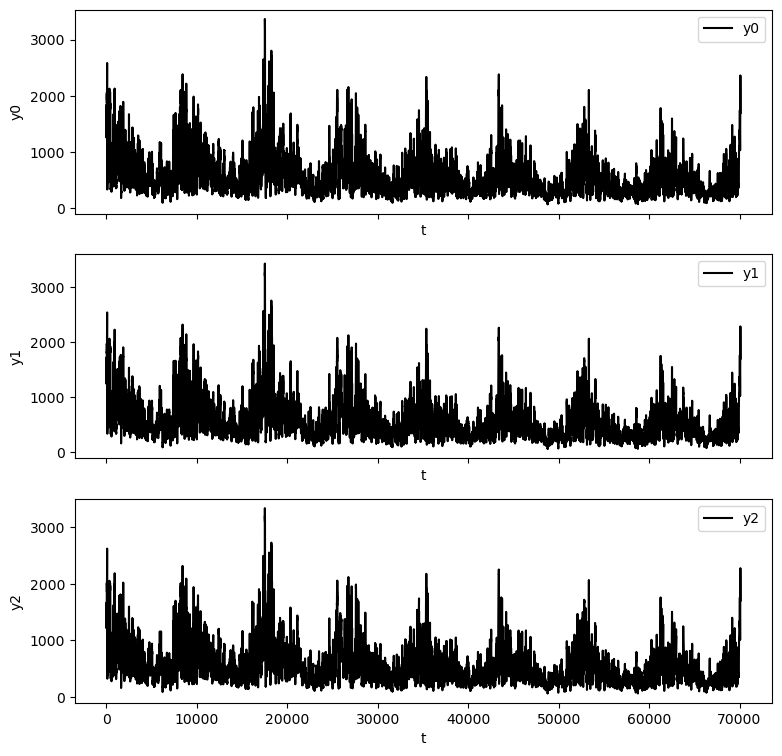

In [24]:
macro_data = H @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

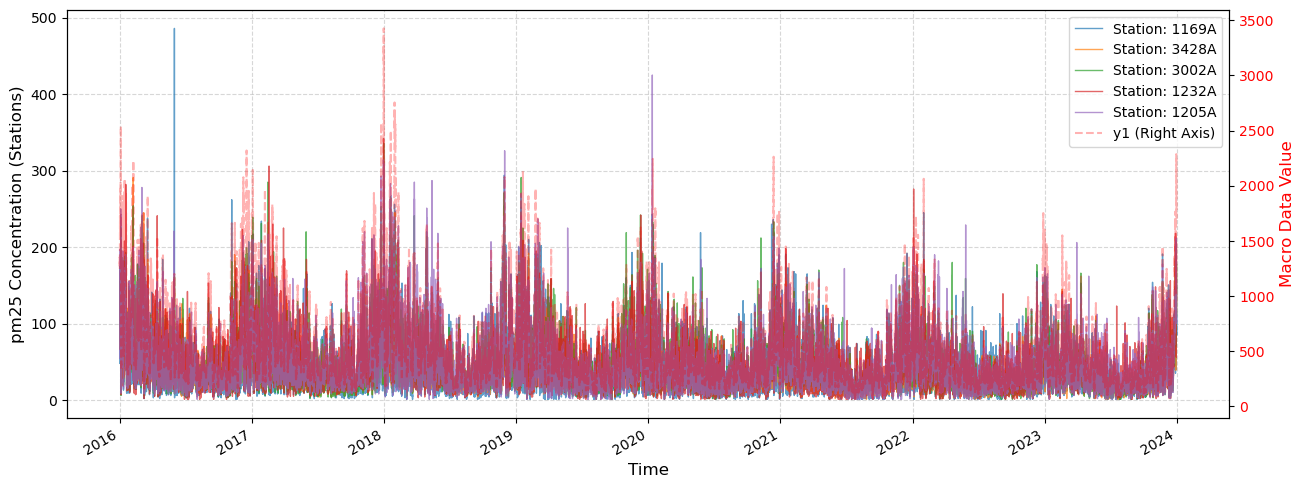

In [29]:
import matplotlib.pyplot as plt

# 1. 使用 subplots 创建画布和第一个坐标轴对象 (ax1)
fig, ax1 = plt.subplots(figsize=(15, 6))

# -------------------------------------------------
# 左侧 Y 轴 (ax1)：绘制各个站点的曲线
# -------------------------------------------------
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('pm25 Concentration (Stations)', fontsize=12) # 左轴标签
ax1.grid(True, linestyle='--', alpha=0.5)
times_final = times[n_delays*delay_interval:]
# 循环绘制选定站点的曲线 (画在 ax1 上)
for idx in selected_indices:
    station_name = stations[idx]
    # 提取数据 (保持原有逻辑)
    station_data = pm25.isel(station=idx).values[n_delays*delay_interval:]
    
    # 注意这里使用的是 ax1.plot
    ax1.plot(times_final, station_data, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# -------------------------------------------------
# 右侧 Y 轴 (ax2)：绘制最后一条宏观数据线
# -------------------------------------------------
ax2 = ax1.twinx()  # 关键步骤：创建共享X轴的第二个Y轴
ax2.set_ylabel('Macro Data Value', color='red', fontsize=12) # 右轴标签，设为红色以区分
ax2.tick_params(axis='y', labelcolor='red') # 设置右轴刻度颜色为红色

# 绘制最后一条线 (画在 ax2 上)
# 注意这里使用的是 ax2.plot
ax2.plot(times_final, macro_data[:, 1], color="red", linestyle='--', alpha=0.3, label=f"y{1} (Right Axis)")

# -------------------------------------------------
# 合并图例 (让两个轴的图例显示在一起)
# -------------------------------------------------
# 分别获取两个轴的图例句柄和标签
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# 合并并显示
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 优化时间轴显示
fig.autofmt_xdate()

plt.show()